## LSTM Model

In [2]:
import glob
import pandas as pd
import numpy as np
from numpy import concatenate
from numpy import sqrt
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    
    return df_data

In [8]:
fpath = "..\\data\\all_raw_files"
model_data_file = "model_data.csv"
model_data = read_data(f'{fpath}\{model_data_file}')

In [9]:
model_data

,year,month,date,temp_mean,temp_min,temp_max,temp_avg_daily_min,temp_avg_daily_max,degree_days,demand_mean,demand_max,demand_avg_daily_max,total_consumption,pv_capacity,population,gsp
0,2010,1,2010-01-01,20.868008,1.6,41.1,16.380645,25.858065,144.511358,8941.450389,13765.04,10613.530000,6554083.135,28278.392,7110454,44504.250000
1,2010,2,2010-02-01,20.218907,3.2,35.4,16.146429,24.682143,124.982743,8855.467677,13377.27,10380.667857,5831325.465,32153.986,7119405,44504.250000
2,2010,3,2010-03-01,19.828286,6.3,34.7,15.496774,24.725806,106.809763,8698.725127,11991.47,10132.978710,6319623.805,38195.588,7128356,44504.250000
3,2010,4,2010-04-01,17.593856,6.5,29.9,12.780000,23.063333,68.136038,8452.863411,11436.13,9804.072333,5984627.295,45142.723,7133668,44504.250000
4,2010,5,2010-05-01,15.323485,3.1,28.4,11.187097,19.596774,123.937772,8897.770510,12386.49,10558.023548,6459781.390,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,2021-08-01,21.104167,16.9,30.7,17.766667,24.966667,9.312500,7368.353056,9043.62,8410.176667,530521.420,3954209.744,8091356,57391.083333
140,2021,9,2021-09-01,20.999306,14.2,27.5,15.433333,25.300000,8.997917,7229.393819,9206.19,8469.680000,520516.355,4033918.477,8088503,57391.083333
141,2021,10,2021-10-01,21.084722,14.8,26.9,16.300000,25.466667,9.254167,7209.823194,8841.21,8575.093333,519107.270,4112353.036,8092743,57391.083333
142,2021,11,2021-11-01,22.118056,15.7,27.3,16.466667,26.566667,12.354167,7649.492569,9573.70,9336.970000,550763.465,4192992.282,8096983,57391.083333


## Decision on data to test, Temp_mean , pv_capacity, population ~ demand_mean_max

In [26]:
model_data_new = model_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]
#Scale the model array
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(model_data_new)
model_data_new = scaler.transform(model_data_new)
# Split training and testing data, testing data is last 24 months
model_data_new.shape
nn_train_x, nn_test_x, nn_train_y, nn_test_y  = train_test_split(model_data_new[ : , 0 : -1], model_data_new[: , -1] , test_size=0.4)

# reshape input to be 3D [samples, timesteps, features]

print(nn_train_x.shape, nn_train_y.shape, nn_test_x.shape, nn_test_y.shape)

(86, 3) (86,) (58, 3) (58,)


In [27]:
nn_train_x

array([[-0.11416365, -0.68025085, -0.21909007],
       [ 0.35755102, -0.3195737 ,  0.62346051],
       [ 0.54528345, -0.0293167 ,  0.86969558],
       [ 0.59335601,  0.34382124,  0.98943235],
       [ 0.00979353, -0.47559784,  0.34977989],
       [ 0.43706447, -0.49679404,  0.28955506],
       [-0.12537975, -0.93692419, -0.87276683],
       [-0.03170068, -0.52766253,  0.19207186],
       [ 0.32594371, -0.27286185,  0.67226501],
       [-0.23768852, -0.75036483, -0.44180752],
       [-0.42143774, -0.8795281 , -0.80254546],
       [ 0.69346939, -0.40602919,  0.50701665],
       [ 0.8045805 , -0.58448437,  0.00986574],
       [-0.36369615, -0.16665987,  0.77078659],
       [ 0.18829932, -0.42690453,  0.47287546],
       [-0.08336674, -0.94818275, -0.88419315],
       [ 0.68406185, -0.80285042, -0.61301866],
       [ 0.55546485, -0.14317258,  0.78346099],
       [ 0.49061224, -0.74034031, -0.41375093],
       [ 0.04079365, -0.54386233,  0.12016111],
       [ 0.80001737, -0.97457749, -0.920

Epoch 1/50
1/1 - 1s - loss: 0.3639 - val_loss: 0.2339 - 962ms/epoch - 962ms/step
Epoch 2/50
1/1 - 0s - loss: 0.2191 - val_loss: 0.1338 - 42ms/epoch - 42ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1296 - val_loss: 0.0853 - 42ms/epoch - 42ms/step
Epoch 4/50
1/1 - 0s - loss: 0.0900 - val_loss: 0.0768 - 35ms/epoch - 35ms/step
Epoch 5/50
1/1 - 0s - loss: 0.0871 - val_loss: 0.0889 - 44ms/epoch - 44ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1003 - val_loss: 0.1021 - 43ms/epoch - 43ms/step
Epoch 7/50
1/1 - 0s - loss: 0.1105 - val_loss: 0.1061 - 39ms/epoch - 39ms/step
Epoch 8/50
1/1 - 0s - loss: 0.1093 - val_loss: 0.0998 - 49ms/epoch - 49ms/step
Epoch 9/50
1/1 - 0s - loss: 0.0976 - val_loss: 0.0869 - 35ms/epoch - 35ms/step
Epoch 10/50
1/1 - 0s - loss: 0.0802 - val_loss: 0.0723 - 46ms/epoch - 46ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0629 - val_loss: 0.0601 - 45ms/epoch - 45ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0497 - val_loss: 0.0527 - 35ms/epoch - 35ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0431 - val_loss:

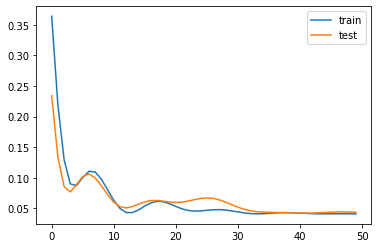

In [28]:
# Run model
# design network
model = Sequential()
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(nn_train_x, nn_train_y, epochs=50, batch_size=124, validation_data=(nn_test_x, nn_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 3ms/step


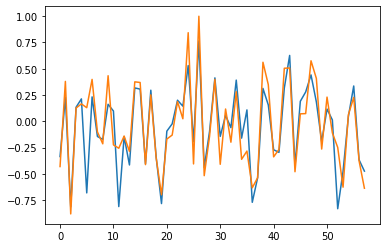

In [32]:
# make a prediction
yhat = model.predict(nn_test_x)
yhat
plt.plot(yhat)
plt.plot(nn_test_y)

In [36]:
nn_test_y

array([-0.43131681,  0.3793413 , -0.88245217,  0.12564423,  0.1654761 ,
        0.12915854,  0.39848929, -0.10120792, -0.21483445,  0.43354167,
       -0.22505003, -0.25706672, -0.1409742 , -0.28700851,  0.37537954,
        0.36921036, -0.41304979,  0.25125658, -0.34861141, -0.70002733,
       -0.16936046, -0.13154892,  0.18713411,  0.02367408,  0.84323636,
       -0.40643274,  1.        , -0.51828321, -0.14247672,  0.39872321,
       -0.40985263,  0.1165278 , -0.19946215,  0.28112718, -0.36245289,
       -0.28384204, -0.63356569, -0.53827125,  0.56182899,  0.34865936,
       -0.33896219, -0.26834003,  0.50482392,  0.50725427, -0.48074061,
        0.07058815,  0.07302467,  0.57589956,  0.40814086, -0.26474499,
        0.22993502, -0.11096126, -0.24898599, -0.62777932,  0.06275121,
        0.22712096, -0.37690006, -0.6379218 ])

In [37]:
# make a prediction
# invert scaling for forecast
inv_yhat = concatenate((nn_test_x, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,3]
# invert scaling for actual
nn_test_y = nn_test_y.reshape((len(nn_test_y), 1))
inv_y = concatenate((nn_test_x, nn_test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 330.864
